# Final project

Se nos ha proporcionado un dataset con información historica del uso de un programa de prueba y el historial de navegación en la web de algunos clientes.

Nuestro objetivo es determinar que influye en la decisión finl de comprar o no el producto, respecto a los datos que tenemos.

**Disclaimer**: Los resultados de los modelos estan comentados en base a la primera ejecución, pensaba que con la opcion 'random_state' de sklearn se fijaba la semilla y los resultados siempre eran iguales, pero parece que dependen de la ejecucion del kernel, asi que los comentarios puede que no se correspondan con los nuevos valores. Disculpad las molestias.

In [1]:
# Carga de librerias

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn import tree

In [2]:
# Unlimit pandas display
pd.set_option('display.max_rows', None)

## ETL

### Extracción

Para extraer los datos primero subimos los ficheros a un repositorio de github publico, para que todo el mundo los pueda usar y los cargamos a un DataFrame de pandas.

Tenemos dos ficheros, uno para hacer el entrenamiento y el testeo de nuestro modelo, con el que vamos a sacar nuestras conclusiones. Y otro para hacer una predicción sobre datos no clasificados con el fin de que la empresa pueda evaluar el rendimiento de nuestro modelo en producción.

In [3]:
# Cargamos los datos

original_data = pd.read_excel('data/data_PQL.xlsx', header = 0, sheet_name = 'RapidMiner Data', engine = 'openpyxl')
data_predict = pd.read_excel('data/data_PQLpredict.xlsx', header = 0, sheet_name = 'RapidMiner Data', engine = 'openpyxl')

/home/m315/anaconda3/lib/python3.9/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


In [4]:
print(original_data.shape)

(282, 308)


In [5]:
original_data.dtypes

starts_2day                                         float64
starts_4day                                         float64
starts_6day                                         float64
starts_8day                                         float64
starts_10day                                        float64
starts_12day                                        float64
starts_14day                                        float64
starts_16day                                        float64
starts_18day                                        float64
starts_20day                                        float64
starts_22day                                        float64
starts_24day                                        float64
starts_26day                                        float64
starts_28day                                        float64
starts_30day                                        float64
starts_4day_Delta                                   float64
starts_6day_Delta                       

### Transformacion

El dataset de train consta de 282 registros y el dataset para la predicción consta de 49, ambos tienen 308 variables, de las cuales una es el target. 

Con la poca cantidad de registros respecto a las variables podemos tener un problema de sobre dimensión, mas aun siendo la mayoria de valores numericos o strings.

El problema de sobredimension ocurre cuando nuestro espació es muy grande, en este caso es potencialmente $\mathbb{R}^{307}$ y las observaciones de las que disponemos son escasas, en nuestro caso 282 (incluso menos si tenemos encuenta que algunas las tendremos que usar para testear el modelo).

Visto este problema vamos a ver si podemos eliminar algunas de las variables y asi reducir la dimensión de nuestro espacio.

In [6]:
# Calculamos los valores no nulos de cada columna
282 - original_data.isnull().sum()

starts_2day                                         282
starts_4day                                         282
starts_6day                                         282
starts_8day                                         282
starts_10day                                        282
starts_12day                                        282
starts_14day                                        282
starts_16day                                        282
starts_18day                                        282
starts_20day                                        282
starts_22day                                        282
starts_24day                                        282
starts_26day                                        282
starts_28day                                        282
starts_30day                                        282
starts_4day_Delta                                   282
starts_6day_Delta                                   282
starts_8day_Delta                               

In [7]:
# Contamos cuantas variables solo tienen 90 registros no nulos
(282 - original_data.isnull().sum()).isin([90])

starts_2day                                         False
starts_4day                                         False
starts_6day                                         False
starts_8day                                         False
starts_10day                                        False
starts_12day                                        False
starts_14day                                        False
starts_16day                                        False
starts_18day                                        False
starts_20day                                        False
starts_22day                                        False
starts_24day                                        False
starts_26day                                        False
starts_28day                                        False
starts_30day                                        False
starts_4day_Delta                                   False
starts_6day_Delta                                   False
starts_8day_De

Vemos que hay 260 variables con pocos registros no nulos, el problema con esto es que si usamos estas variables para entrenar el modelo puede que en producción tambien sean nulos y no nos ayuden en nada. Ademas para tan pocos registros el problema de dimensionalidad es un peor, asi que el modelo es complicado que pueda sacar alguna conclusión con estas variables y en el caso de que lo haga sera difícil decidir si producen overfitting o sesgo.

Entonces tenemos varias opciones. 

Por un lado podemos quitar todas estas variables. 

Por otro lado podemos rellenar los datos que faltan de alguna manera. Por los nombres de las variables podemos interpretar que se trata del uso del programa, asi que para rellenar los null's usar medias podria llevar a muchos errores y ponerlos todos a 0 tambien, ya que agruparemos todas las filas con null's mientras el resto estaran muy dispersas y esto podria generar ruido en el modelo.

Una ultima opción es coger los registros que tengan alguna de estas variables sin null's y generar una columna indicandolo, una vez creada esta columna podemos eliminar el resto para asi reducir las variables.

Nos vamos a decantar por esta ultima opción ya que parece la más razonable balanceando la perdida de información y la reducción de dimensiones.

In [8]:
# Generamos una lista de las columnas con nulls
a = (282 - original_data.isnull().sum()).isin([90])
null_col = a[a].index
null_col

Index(['countsum_retrieve', 'countsum_apply_model', 'countsum_filter_examples',
       'countsum_join', 'countsum_nominal_conversion',
       'countsum_numerical_conversion', 'countsum_parallel_decision_tree',
       'countsum_performance', 'countsum_read_data_operators',
       'countsum_remove_duplicates',
       ...
       'countsum_FAILURE', 'countsum_RUNTIME_EXCEPTION', 'countsum_USER_ERROR',
       'countsum_OPERATOR_EXCEPTION', 'countsum_STOPPED', 'failure_ratio',
       'runtime_exception_ratio', 'user_error_ratio',
       'operator_exception_ratio', 'stopped_ratio'],
      dtype='object', length=260)

In [9]:
# Creamos una variable nueva indicando si el usuario tiene algun registro de uso del programa o no
transformation1 = original_data.copy()
transformation1['registered_usage'] = original_data[null_col].any(axis=1).replace({False: 0., True: 1.})

In [10]:
# Eliminamos las columnas de uso dejando la nueva columna

transformation2 = transformation1.drop(columns = null_col)

In [11]:
transformation2.head()

,starts_2day,starts_4day,starts_6day,starts_8day,starts_10day,starts_12day,starts_14day,starts_16day,starts_18day,starts_20day,...,Social Post ClickC,Paid Search AdC,VideoC,country,industry,job_function,job_title,IsWon,id,registered_usage
0,15.0,17.0,17.0,18.0,18.0,18.0,19.0,19.0,19.0,19.0,...,0.0,0.0,0.0,Russia,Non-Profit,Researcher,Data Scientist/ consultant,True,1.0,1.0
1,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,5.0,5.0,...,0.0,0.0,0.0,United States,Media/Entertainment,Business - Management,Managing Director,False,2.0,0.0
2,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,Hungary,Other,Other,Data Scientist/ consultant,False,3.0,0.0
3,2.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,...,0.0,0.0,0.0,Malaysia,Business Services,Partner-Reseller,Business Development Director,True,5.0,0.0
4,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,United States,Healthcare/Pharmaceuticals/Biotech,Data Scientist,Data Scientist/ consultant,True,6.0,0.0


Ahora ya tenemos muchas menos variables aunque siguen siendo bastantes dada la candidad de registros de los que disponemos.

Vamos a ver ahora si hay algunas variables muy correlacionadas entre ellas.

<AxesSubplot:>

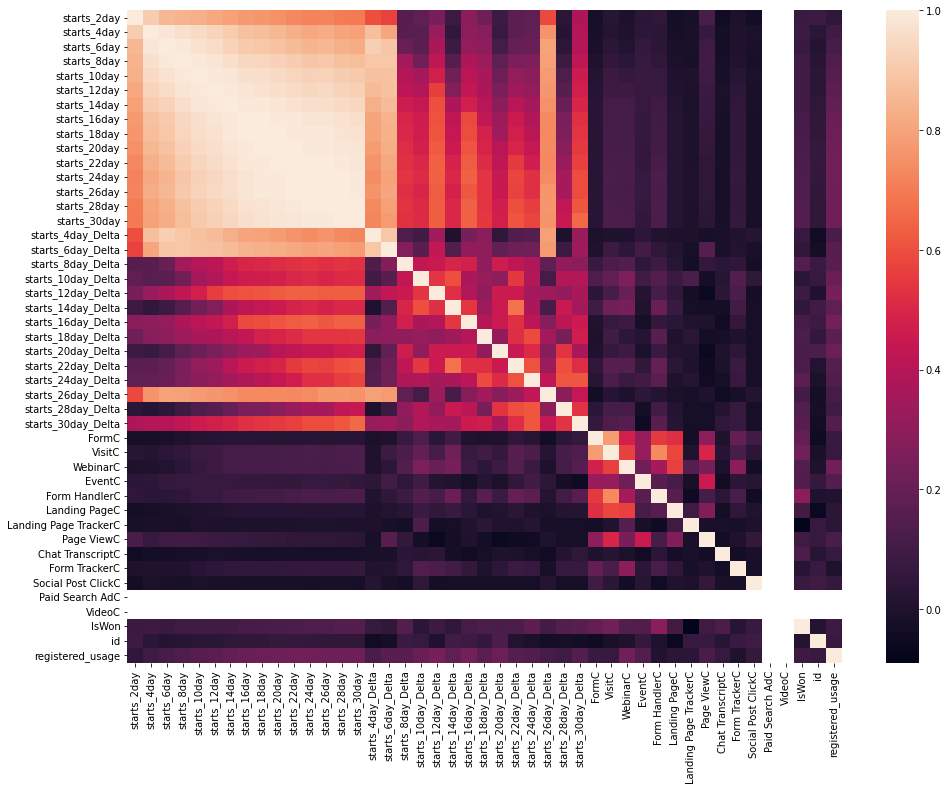

In [12]:
# Usamos la función heatmap de Seaborn:

plt.figure(figsize = (16, 12))
sns.heatmap(transformation2.corr(), annot = False)

Vemos que hay mucha correlación con las primeras variables y tambien pasa algo raro con las columnas 'Paid Search AdC' y 'VideoC'.

In [13]:
# Miramos los valores unicos para las columnas 'Paid Search AdC' y 'VideoC'

print('Paid Search AdC unique values: ', transformation2['Paid Search AdC'].unique())
print('VideoC unique values: ', transformation2['VideoC'].unique())

Paid Search AdC unique values:  [0.]
VideoC unique values:  [0.]


Vemos que todos los registros de estas columnas son 0 asi que no tiene mucho sentido usarlas para el modelo ya que no aportan ninguna información.

In [14]:
# Eliminamos las columnas con solo zeros

transformation3 = transformation2.drop(columns =['Paid Search AdC', 'VideoC'])

Miramos que pasa con las columnas que tienen una alta correlación, para ello tambien cojeremos las 'starts_xday_Delta' ya que por el nombre parece que pueden estar relacionadas tambien

In [15]:
# Seleccionamos las columans 'starts...'
starts_col = transformation3.columns[:29]

# Mostramos los datos de estas columnas
transformation3[starts_col].T

,0,1,2,3,4,5,6,7,8,9,...,272,273,274,275,276,277,278,279,280,281
starts_2day,15.0,4.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,2.0,...,4.0,1.0,1.0,3.0,2.0,2.0,1.0,4.0,7.0,5.0
starts_4day,17.0,4.0,1.0,3.0,1.0,1.0,1.0,1.0,1.0,3.0,...,4.0,1.0,1.0,3.0,2.0,4.0,1.0,7.0,7.0,6.0
starts_6day,17.0,4.0,1.0,3.0,1.0,1.0,1.0,1.0,1.0,3.0,...,6.0,1.0,3.0,3.0,2.0,4.0,1.0,7.0,7.0,7.0
starts_8day,18.0,4.0,1.0,3.0,1.0,1.0,1.0,1.0,1.0,3.0,...,6.0,1.0,4.0,5.0,2.0,10.0,1.0,9.0,10.0,8.0
starts_10day,18.0,4.0,1.0,3.0,1.0,1.0,1.0,1.0,1.0,3.0,...,6.0,1.0,4.0,6.0,2.0,10.0,1.0,12.0,13.0,9.0
starts_12day,18.0,4.0,1.0,3.0,1.0,1.0,1.0,1.0,1.0,3.0,...,6.0,1.0,4.0,6.0,2.0,13.0,1.0,14.0,13.0,15.0
starts_14day,19.0,4.0,1.0,3.0,1.0,1.0,1.0,1.0,1.0,3.0,...,6.0,1.0,4.0,6.0,2.0,15.0,1.0,14.0,22.0,16.0
starts_16day,19.0,4.0,1.0,3.0,1.0,2.0,1.0,1.0,1.0,3.0,...,6.0,1.0,4.0,8.0,3.0,22.0,1.0,14.0,27.0,17.0
starts_18day,19.0,5.0,1.0,3.0,1.0,2.0,1.0,1.0,1.0,3.0,...,6.0,1.0,4.0,8.0,3.0,22.0,1.0,14.0,28.0,18.0
starts_20day,19.0,5.0,1.0,3.0,1.0,2.0,1.0,1.0,1.0,3.0,...,10.0,1.0,4.0,8.0,3.0,26.0,1.0,15.0,29.0,26.0


Parece que 'starts_xday' es la suma acumulativa y que 'starts_xday_Delta' es el incremental. Vamos a comprobarlo.

In [16]:
# Seleccionamos las columans 'starts_xday'
starts_col_no_delta = transformation3.columns[:15]

# Mostramos los datos de estas columnas
col_no_delta = transformation3[starts_col_no_delta]
col_no_delta.T

,0,1,2,3,4,5,6,7,8,9,...,272,273,274,275,276,277,278,279,280,281
starts_2day,15.0,4.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,2.0,...,4.0,1.0,1.0,3.0,2.0,2.0,1.0,4.0,7.0,5.0
starts_4day,17.0,4.0,1.0,3.0,1.0,1.0,1.0,1.0,1.0,3.0,...,4.0,1.0,1.0,3.0,2.0,4.0,1.0,7.0,7.0,6.0
starts_6day,17.0,4.0,1.0,3.0,1.0,1.0,1.0,1.0,1.0,3.0,...,6.0,1.0,3.0,3.0,2.0,4.0,1.0,7.0,7.0,7.0
starts_8day,18.0,4.0,1.0,3.0,1.0,1.0,1.0,1.0,1.0,3.0,...,6.0,1.0,4.0,5.0,2.0,10.0,1.0,9.0,10.0,8.0
starts_10day,18.0,4.0,1.0,3.0,1.0,1.0,1.0,1.0,1.0,3.0,...,6.0,1.0,4.0,6.0,2.0,10.0,1.0,12.0,13.0,9.0
starts_12day,18.0,4.0,1.0,3.0,1.0,1.0,1.0,1.0,1.0,3.0,...,6.0,1.0,4.0,6.0,2.0,13.0,1.0,14.0,13.0,15.0
starts_14day,19.0,4.0,1.0,3.0,1.0,1.0,1.0,1.0,1.0,3.0,...,6.0,1.0,4.0,6.0,2.0,15.0,1.0,14.0,22.0,16.0
starts_16day,19.0,4.0,1.0,3.0,1.0,2.0,1.0,1.0,1.0,3.0,...,6.0,1.0,4.0,8.0,3.0,22.0,1.0,14.0,27.0,17.0
starts_18day,19.0,5.0,1.0,3.0,1.0,2.0,1.0,1.0,1.0,3.0,...,6.0,1.0,4.0,8.0,3.0,22.0,1.0,14.0,28.0,18.0
starts_20day,19.0,5.0,1.0,3.0,1.0,2.0,1.0,1.0,1.0,3.0,...,10.0,1.0,4.0,8.0,3.0,26.0,1.0,15.0,29.0,26.0


In [17]:
# Seleccionamos las columans 'starts_xday_Delta'
starts_col_delta = transformation3.columns[15:29]

# Mostramos los datos de estas columnas
col_delta = transformation3[starts_col_delta]
col_delta.T

,0,1,2,3,4,5,6,7,8,9,...,272,273,274,275,276,277,278,279,280,281
starts_4day_Delta,2.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,2.0,0.0,3.0,0.0,1.0
starts_6day_Delta,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
starts_8day_Delta,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,2.0,0.0,6.0,0.0,2.0,3.0,1.0
starts_10day_Delta,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,3.0,3.0,1.0
starts_12day_Delta,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,3.0,0.0,2.0,0.0,6.0
starts_14day_Delta,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,9.0,1.0
starts_16day_Delta,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,1.0,7.0,0.0,0.0,5.0,1.0
starts_18day_Delta,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
starts_20day_Delta,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,4.0,0.0,0.0,0.0,0.0,4.0,0.0,1.0,1.0,8.0
starts_22day_Delta,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,2.0,1.0


In [18]:
# Volvemos a transponer el Data frame
col_no_delta.T

# Creamos un data frame vacio
no_delta = pd.DataFrame()
for i in range(1, col_no_delta.shape[1]):
    # En cada columna calculamos la diferencia entre las acumuladas y las comparmos con la Delta
    no_delta[starts_col_delta[i - 1]] = \
        (col_no_delta[starts_col_no_delta[i]] - col_no_delta[starts_col_no_delta[i - 1]]) \
        != col_delta[starts_col_delta[i - 1]]

# Comprobamos si hay algun valor distinto
no_delta.any()

starts_4day_Delta     False
starts_6day_Delta     False
starts_8day_Delta     False
starts_10day_Delta    False
starts_12day_Delta    False
starts_14day_Delta    False
starts_16day_Delta    False
starts_18day_Delta    False
starts_20day_Delta    False
starts_22day_Delta    False
starts_24day_Delta    False
starts_26day_Delta    False
starts_28day_Delta    False
starts_30day_Delta    False
dtype: bool

Vemos que realmente 'starts_xday' es la suma acumulativa y que 'starts_xday_Delta' es el incremental. Entonces podemos eliminar uno de los dos conjuntos, el incremental o la sumas acumulativas debido a que la información que aportan la podemos sacar con una combinación lineal de las varaibles que dejemos.

Cualquier modelo que use transformaciónes lineales de las variables como las redes neuronales o una regresión logistica va a tener esta información implicita.

Pero modelos como el desicion tree que se basan examinar cada una de las variables pueden tener problemas con esta falta de información.

Vamos a dejar las deltas junto con el valor inicial (start_2day) y la suma total (start_30day) para asi asegurarnos que si usamos algun modelo que no tenga esta capacidad de hacer transformaciones lienales no le falte información.

In [19]:
# Seleccionamos las columnas que vamos a eliminar
start_remove = transformation3.columns[1:14]

# Eliminamos las columnas
transformation4 = transformation3.drop(columns = start_remove)

transformation4.head()

,starts_2day,starts_30day,starts_4day_Delta,starts_6day_Delta,starts_8day_Delta,starts_10day_Delta,starts_12day_Delta,starts_14day_Delta,starts_16day_Delta,starts_18day_Delta,...,Chat TranscriptC,Form TrackerC,Social Post ClickC,country,industry,job_function,job_title,IsWon,id,registered_usage
0,15.0,19.0,2.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,Russia,Non-Profit,Researcher,Data Scientist/ consultant,True,1.0,1.0
1,4.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,United States,Media/Entertainment,Business - Management,Managing Director,False,2.0,0.0
2,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,Hungary,Other,Other,Data Scientist/ consultant,False,3.0,0.0
3,2.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,Malaysia,Business Services,Partner-Reseller,Business Development Director,True,5.0,0.0
4,1.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,United States,Healthcare/Pharmaceuticals/Biotech,Data Scientist,Data Scientist/ consultant,True,6.0,0.0


Volvemos a mirar la correlación a ver si ahora es mejor o debemos modificar algo mas.

<AxesSubplot:>

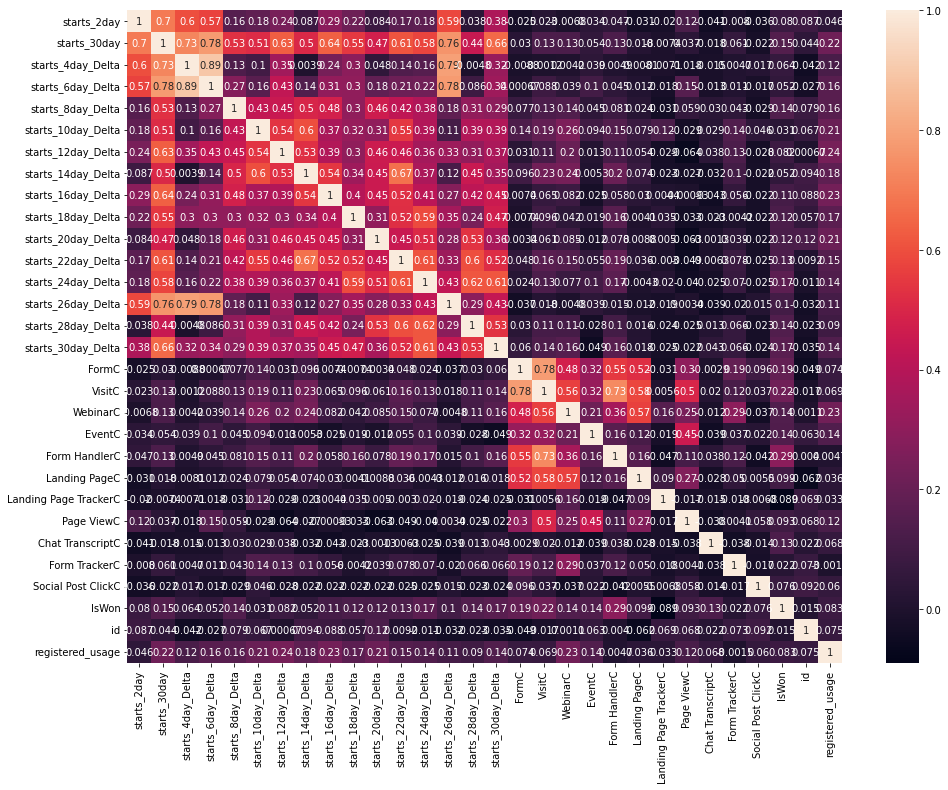

In [20]:
# Usamos la función heatmap de Seaborn:

plt.figure(figsize = (16, 12))
sns.heatmap(transformation4.corr(), annot = True)

Parece que ha mejorado bastante y que el hecho de dejar la columna con la suma total no es tan malo como poria parecer.

Como tenemos una cantidad muy reducida de datos no tiene mucho sentido eliminar outliers, pero aun asi vamos a comprobar que no haya algun dato que querramos descartar.

In [21]:
transformation4.describe().T

,count,mean,std,min,25%,50%,75%,max
starts_2day,282.0,4.216312,7.263178,1.0,1.00,2.0,5.00,73.0
starts_30day,282.0,13.347518,26.782367,1.0,2.25,6.0,14.00,322.0
starts_4day_Delta,282.0,1.021277,6.201215,0.0,0.00,0.0,1.00,102.0
starts_6day_Delta,282.0,0.929078,4.454827,0.0,0.00,0.0,0.00,68.0
starts_8day_Delta,282.0,0.953901,2.616945,0.0,0.00,0.0,1.00,24.0
starts_10day_Delta,282.0,0.726950,2.235252,0.0,0.00,0.0,0.00,25.0
starts_12day_Delta,282.0,0.673759,1.962265,0.0,0.00,0.0,0.00,17.0
starts_14day_Delta,282.0,0.592199,2.149322,0.0,0.00,0.0,0.00,28.0
starts_16day_Delta,282.0,0.840426,3.044053,0.0,0.00,0.0,0.00,32.0
starts_18day_Delta,282.0,0.397163,1.477612,0.0,0.00,0.0,0.00,16.0


/tmp/ipykernel_13587/3081699530.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize = (10,5))


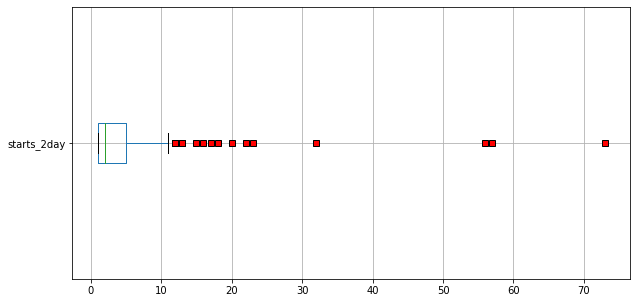

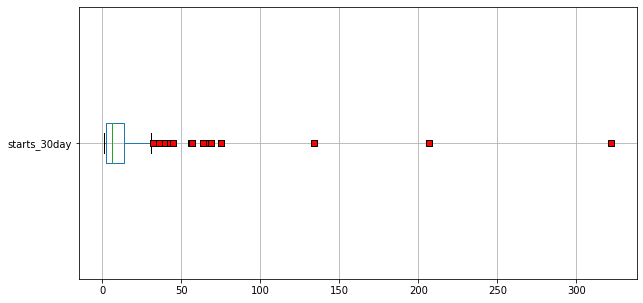

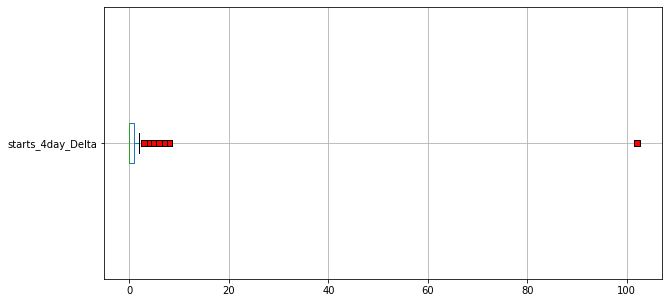

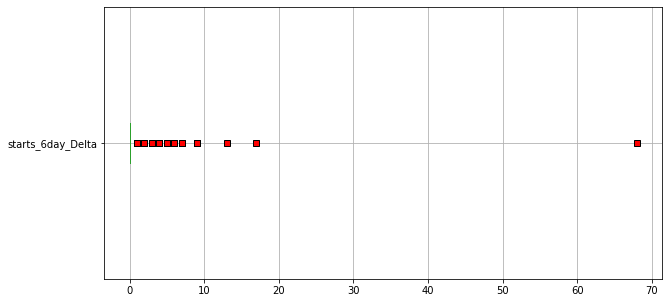

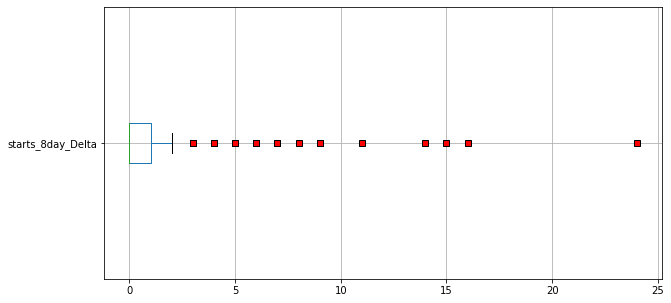

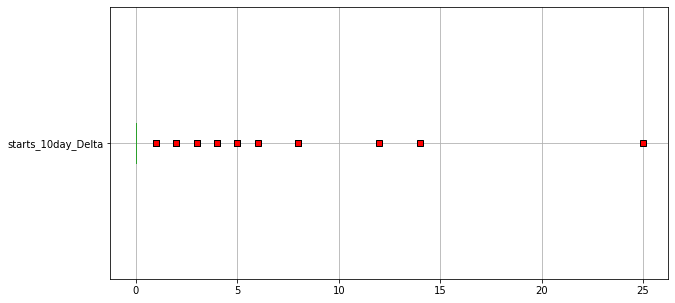

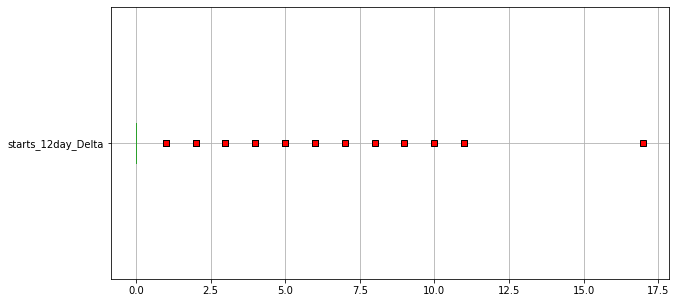

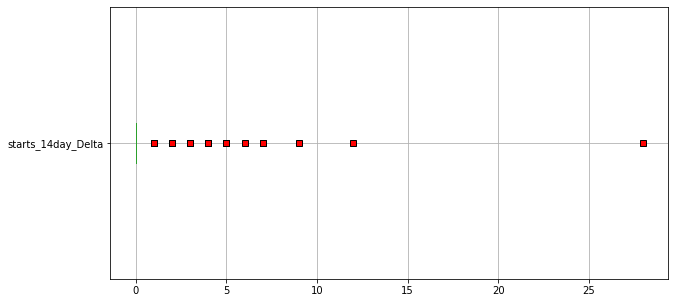

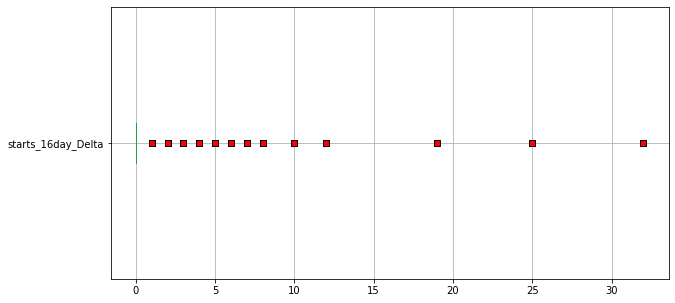

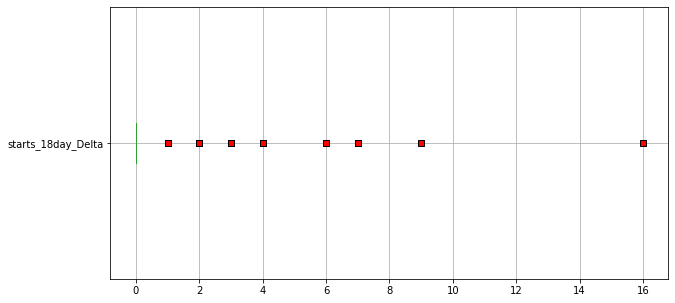

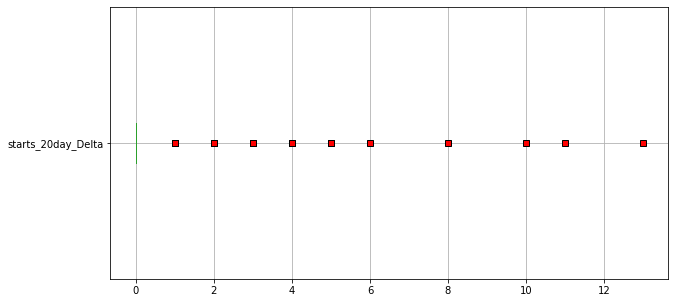

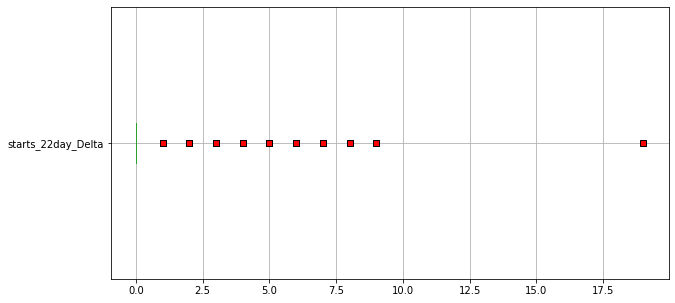

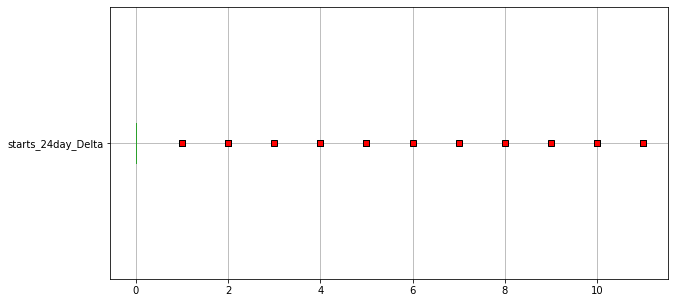

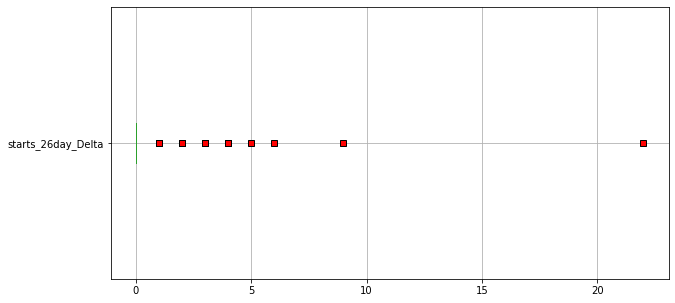

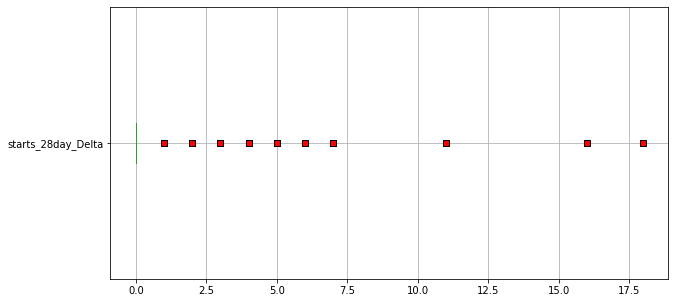

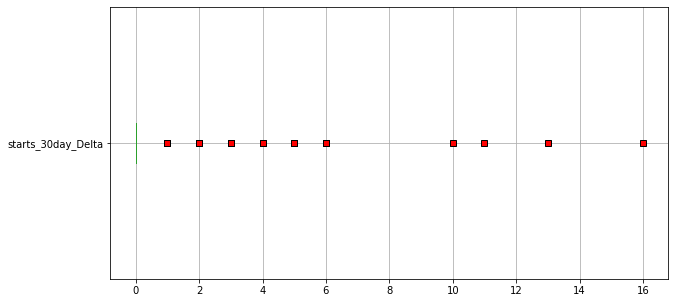

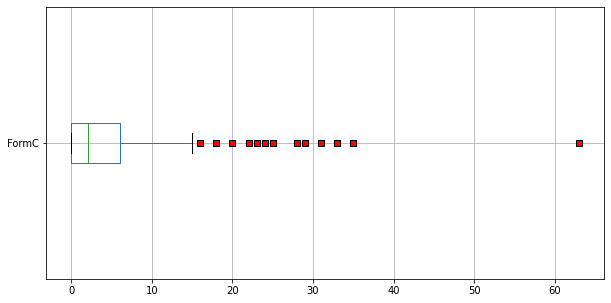

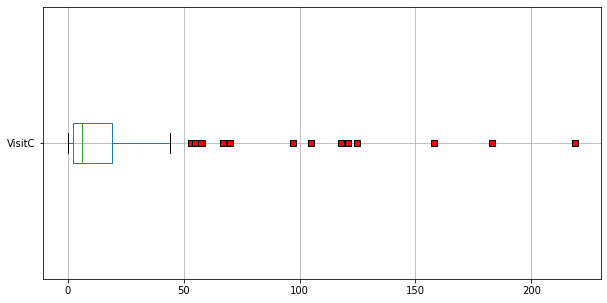

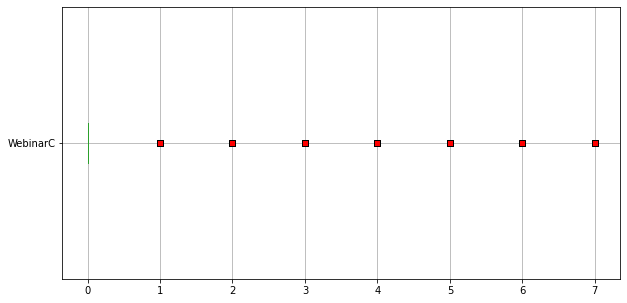

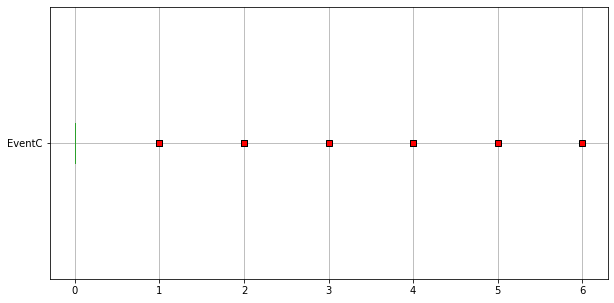

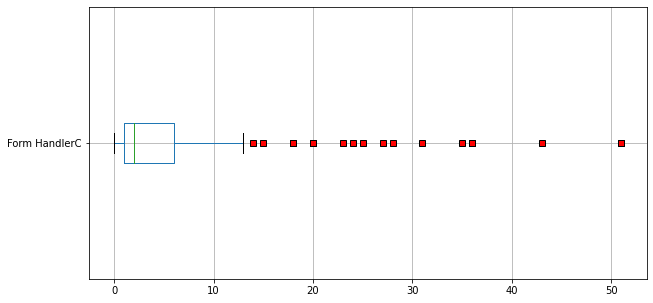

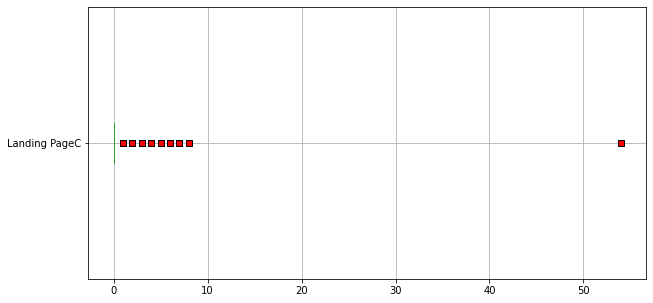

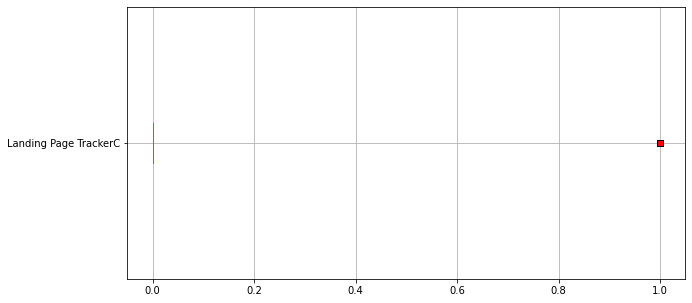

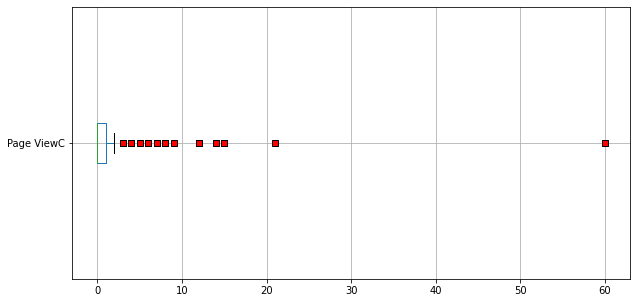

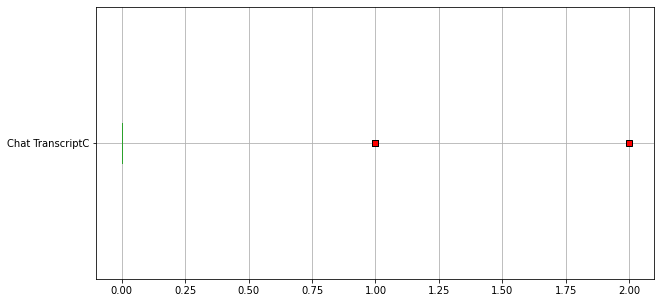

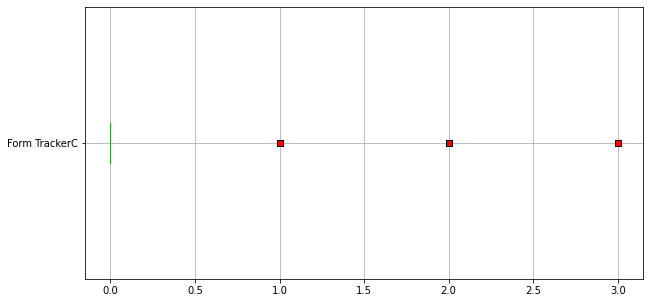

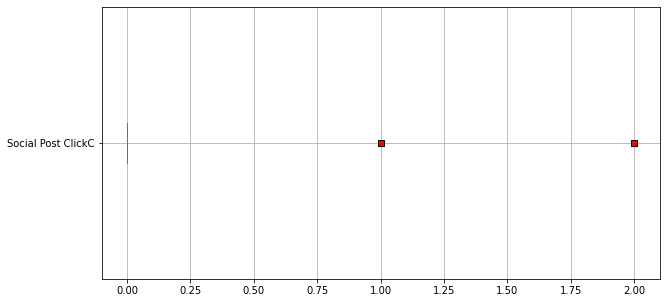

In [22]:
# Usamos matplotlib para visualizar los datos en box plot, y definimos un bucle para que itere por cada columna

for column in transformation4.columns[:27]:
    fig = plt.figure(figsize = (10,5))
    red_square = dict(markerfacecolor = 'r', marker = 's')
    transformation4.boxplot([column], vert = False, flierprops = red_square)

Parece que hay algunos outliers pero se debe a que muchas variables estan muy agrupadas a un valor y esto hace que "destaquen" pero son valores plausibles como 60 visitas a una pagina, no son demasiado inverosímiles.

Asi que las vamos a dejar.

Finalmente falta transformar las variables 'country', 'industry', 'job_function' y 'job_title' de string a numerico y la variable objetivo ('IsWon') de bool a numerico.

In [23]:
# Pasamos de bool a numerico la variable objetivo

transformation4['IsWon'] = transformation4['IsWon'].replace({False: 0, True: 1})
transformation4.head()

,starts_2day,starts_30day,starts_4day_Delta,starts_6day_Delta,starts_8day_Delta,starts_10day_Delta,starts_12day_Delta,starts_14day_Delta,starts_16day_Delta,starts_18day_Delta,...,Chat TranscriptC,Form TrackerC,Social Post ClickC,country,industry,job_function,job_title,IsWon,id,registered_usage
0,15.0,19.0,2.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,Russia,Non-Profit,Researcher,Data Scientist/ consultant,1,1.0,1.0
1,4.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,United States,Media/Entertainment,Business - Management,Managing Director,0,2.0,0.0
2,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,Hungary,Other,Other,Data Scientist/ consultant,0,3.0,0.0
3,2.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,Malaysia,Business Services,Partner-Reseller,Business Development Director,1,5.0,0.0
4,1.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,United States,Healthcare/Pharmaceuticals/Biotech,Data Scientist,Data Scientist/ consultant,1,6.0,0.0


In [24]:
# Creamos listas para hacer las transformaciones de string a numerico
# Usamos tanto el dataset de train como el de predict para asegurarnos que todos los valores estan

country_legend = list(pd.concat([data_predict['country'], transformation4['country']]).unique())
industry_legend = list(pd.concat([data_predict['industry'], transformation4['industry']]).unique())
job_function_legend = list(pd.concat([data_predict['job_function'], transformation4['job_function']]).unique())
job_title_legend = list(pd.concat([data_predict['job_title'], transformation4['job_title']]).unique())

In [25]:
print(len(country_legend))
print(len(industry_legend))
print(len(job_function_legend))
print(len(job_title_legend))

49
29
32
129


In [26]:
job_title_legend

['Executive Director',
 'Data Scientist/ consultant',
 'Mr.',
 'SAS Consultant',
 'Metabiomics',
 'Value Added Service Architect',
 'Director of BI',
 'Development Database Manager',
 'Principal',
 'Customer, Branch and Dealer Systems',
 'Analytics Leader',
 'Business Development Manager - Marketing Division',
 'Associate',
 'Business Analyst',
 'Individual',
 'Technical Analyst',
 'Optimization Research Engineer',
 'Technical Architect',
 'Not Sure',
 'Reliability Centered Maintenance Manager',
 'Director',
 'Managing Director',
 'Business Development Director',
 'AgilebI Architect',
 'Vice President and Head - Marketing Analytics',
 'Director of Analytics',
 'Consumer & Market Knowledge',
 'Principal Engineer',
 'Sr. Customer Data Analyst',
 'SVP R&D',
 'Data Scientist',
 'CRM BI',
 'Loss Prevention Analyst',
 'Founder',
 'Vice President, Analytics and Intelligence',
 'Data Scientist - Head of models',
 'owner',
 'Director of Artificial Intelligence',
 'Director Business Intelligence

Vemos que hay muchos valores en 'job_title' y que algunos de ellos son muy arbitrarios e incluso estan en idiomas distintos. Asi que podemos considerar eliminar esta columna ya que nos puede producir ruido en el modelo y ademas no podemos asegurar que en produccion haya valores nuevos distintos o con algun cambio que por culpa de esto no podamos clasificar.

In [27]:
# Eliminamos la columna de job title

transformation5 = transformation4.drop(columns = 'job_title')

Ahora debemos cambiar los valores de nuestro data frame por los valores numericos de las leyendas que hemos creado

In [28]:
# Cambiamos cada valor del dataframe por su valor en la leyenda

transformation5['country'], country_legend = pd.factorize(pd.Categorical(transformation5['country'], categories = country_legend))
transformation5['industry'], industry_legend = pd.factorize(pd.Categorical(transformation5['industry'], categories = industry_legend))
transformation5['job_function'], job_function_legend = pd.factorize(pd.Categorical(transformation5['job_function'], categories = job_function_legend))

In [29]:
transformation5.head()

,starts_2day,starts_30day,starts_4day_Delta,starts_6day_Delta,starts_8day_Delta,starts_10day_Delta,starts_12day_Delta,starts_14day_Delta,starts_16day_Delta,starts_18day_Delta,...,Page ViewC,Chat TranscriptC,Form TrackerC,Social Post ClickC,country,industry,job_function,IsWon,id,registered_usage
0,15.0,19.0,2.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,6.0,0.0,0.0,0.0,0,0,0,1,1.0,1.0
1,4.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,1,1,1,0,2.0,0.0
2,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3.0,0.0,0.0,0.0,2,2,2,0,3.0,0.0
3,2.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,3,3,3,1,5.0,0.0
4,1.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1,4,4,1,6.0,0.0


### Carga

Ya tenemos el data set mas limpio, solo falta eliminar la varialbe 'id' ya que no aporta información para la predicción y empezar a entrenar.

Despues ya veremos si hacemos o deshacemos tranformaciones extra para mejorar el modelo.

Cuando ya hayamos decidido que modelo y estructura de datos es la mejor deberemos hacer el mismo proceso de ETL para el data set de predicciones.

In [30]:
# Eliminamos la columna de id

clean_data = transformation5.drop(columns = 'id')

## Modelo 1

In [31]:
# Comprobamos el desbalanceo de nuestros datos antes de seguir

class_0 = clean_data[clean_data['IsWon'] == 0].value_counts()
class_1 = clean_data[clean_data['IsWon'] == 1].value_counts()

print('class 0: ', class_0.shape[0])
print('class 1: ', class_1.shape[0])

class 0:  130
class 1:  148


Los datos estan bien balaceados, asi que no hace falta que los modifiquemos para el entreno del modelo.

In [32]:
# Extraemos nuestra variable objetivo de las variables predictoras

y = clean_data.pop('IsWon')

In [33]:
# Dividimos los datos en entrenamiento y testeo, estableciendo un 20% para test y un 80% para train
# Usamos la función train_test_split de scikit learn

X_train, X_test, y_train, y_test = train_test_split (clean_data, y, test_size = 0.20)

### Desicion Tree

In [34]:
# Generamos el modelo de Decision Tree

dt = DecisionTreeClassifier(max_leaf_nodes = 4, random_state = 1)
dt.fit(X_train, y_train)

DecisionTreeClassifier(max_leaf_nodes=4, random_state=1)

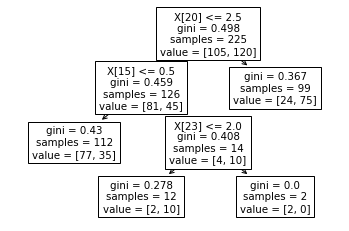

In [35]:
# Print the tree

tree.plot_tree(dt)
plt.show()

AUC:  0.6140350877192983
Precision:  0.6206896551724138
Recall:  0.6206896551724138


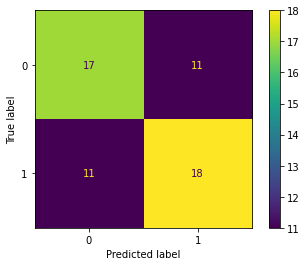

In [36]:
# Evaluación del modelo:

# Aplicamos el modelo a X_test
dt_predictions = dt.predict(X_test)

# Obtenemos el accuracy, la precision y el recall
print('AUC: ', metrics.accuracy_score(y_test, dt_predictions))
print('Precision: ', metrics.precision_score(y_test, dt_predictions))
print('Recall: ', metrics.recall_score(y_test, dt_predictions))

# Calculamos la matrix de confusion
ConfusionMatrixDisplay.from_predictions(y_test, dt_predictions)
plt.show()

### Regresion Logistica

AUC:  0.6140350877192983
Precision:  0.6521739130434783
Recall:  0.5172413793103449


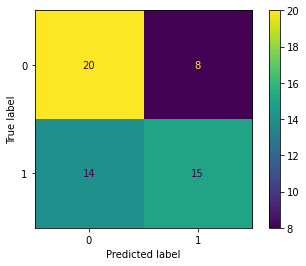

In [37]:
# Aplicamos el modelo de regresión logística.

lr = LogisticRegression(max_iter = 1000, random_state = 1).fit(X_train, y_train)


# Evaluación del modelo:

# Aplicamos el modelo a X_test
lr_predictions = lr.predict(X_test)

# Obtenemos el accuracy, la precision y el recall
print('AUC: ', metrics.accuracy_score(y_test, lr_predictions))
print('Precision: ', metrics.precision_score(y_test, lr_predictions))
print('Recall: ', metrics.recall_score(y_test, lr_predictions))

# Calculamos la matrix de confusion
ConfusionMatrixDisplay.from_predictions(y_test, lr_predictions)
plt.show()

### Random forest

AUC:  0.631578947368421
Precision:  0.625
Recall:  0.6896551724137931


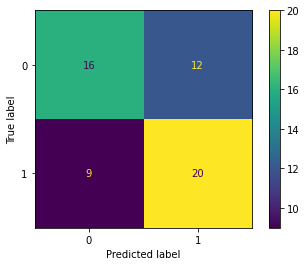

In [38]:
# Aplicamos el modelo de random forest

rf = RandomForestClassifier(max_depth = 4, random_state = 1).fit(X_train, y_train)


# Evaluación del modelo:

# Aplicamos el modelo a X_test
rf_predictions = rf.predict(X_test)

# Obtenemos el accuracy, la precision y el recall
print('AUC: ', metrics.accuracy_score(y_test, rf_predictions))
print('Precision: ', metrics.precision_score(y_test, rf_predictions))
print('Recall: ', metrics.recall_score(y_test, rf_predictions))

# Calculamos la matrix de confusion
ConfusionMatrixDisplay.from_predictions(y_test, rf_predictions)
plt.show()

Con los tres modelos tenemos un AUC, una precision y sobretodo un recall bajos, pero son bastante susceptibles al rng del entrenatimento debido a que tenemos muy poco regsitros.

## Modelo 2

Podemos probar a eliminar las variables que antes eran strings del dataset ya que como hemos visto pueden generar problemas en producción si se añade algun valor que no tenemos y ademas al pasarlo a valor numerico los modelos interprentan que tiene un orden, por ejemplo Spain < Sweden que no tiene ningun argumento detras ya que la indexación se ha hecho sin ningun criterio de este tipo.

In [39]:
# Quitamos las variables que eran strings

clean_data_2 = transformation5.drop(columns = ['id', 'country', 'industry', 'job_function'])

In [40]:
# Extraemos nuestra variable objetivo de las variables predictoras

y_2 = clean_data_2.pop('IsWon')

In [41]:
# Dividimos los datos en entrenamiento y testeo, estableciendo un 20% para test y un 80% para train
# Usamos la función train_test_split de scikit learn

X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split (clean_data_2, y_2, test_size = 0.20)

### Desicion Tree

In [42]:
# Generamos el modelo de Decision Tree

dt_2 = DecisionTreeClassifier(max_leaf_nodes = 4, random_state = 1)
dt_2.fit(X_train_2, y_train_2)

DecisionTreeClassifier(max_leaf_nodes=4, random_state=1)

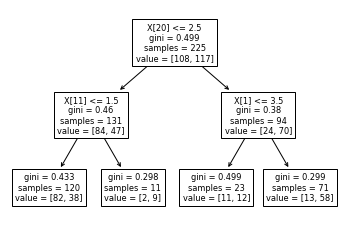

In [43]:
# Print the tree

tree.plot_tree(dt_2)
plt.show()

AUC:  0.6491228070175439
Precision:  0.6875
Recall:  0.6875


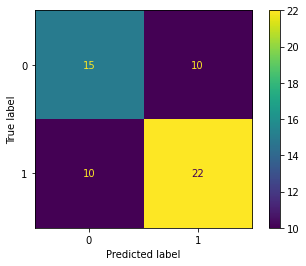

In [44]:
# Evaluación del modelo:

# Aplicamos el modelo a X_test
dt_predictions_2 = dt_2.predict(X_test_2)

# Obtenemos el accuracy, la precision y el recall
print('AUC: ', metrics.accuracy_score(y_test_2, dt_predictions_2))
print('Precision: ', metrics.precision_score(y_test_2, dt_predictions_2))
print('Recall: ', metrics.recall_score(y_test_2, dt_predictions_2))

# Calculamos la matrix de confusion
ConfusionMatrixDisplay.from_predictions(y_test_2, dt_predictions_2)
plt.show()

### Regresion Logistica

AUC:  0.631578947368421
Precision:  0.7037037037037037
Recall:  0.59375


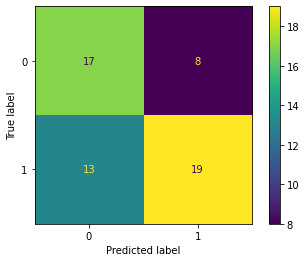

In [45]:
# Aplicamos el modelo de regresión logística.

lr_2 = LogisticRegression(max_iter = 1000, random_state = 1).fit(X_train_2, y_train_2)


# Evaluación del modelo:

# Aplicamos el modelo a X_test
lr_predictions_2 = lr_2.predict(X_test_2)

# Obtenemos el accuracy, la precision y el recall
print('AUC: ', metrics.accuracy_score(y_test_2, lr_predictions_2))
print('Precision: ', metrics.precision_score(y_test_2, lr_predictions_2))
print('Recall: ', metrics.recall_score(y_test_2, lr_predictions_2))

# Calculamos la matrix de confusion
ConfusionMatrixDisplay.from_predictions(y_test_2, lr_predictions_2)
plt.show()

### Random forest

AUC:  0.6140350877192983
Precision:  0.6666666666666666
Recall:  0.625


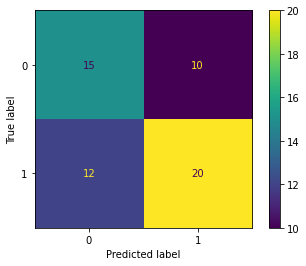

In [46]:
# Aplicamos el modelo de random forest

rf_2 = RandomForestClassifier(max_depth = 4, random_state = 1).fit(X_train_2, y_train_2)


# Evaluación del modelo:

# Aplicamos el modelo a X_test
rf_predictions_2 = rf_2.predict(X_test_2)

# Obtenemos el accuracy, la precision y el recall
print('AUC: ', metrics.accuracy_score(y_test_2, rf_predictions_2))
print('Precision: ', metrics.precision_score(y_test_2, rf_predictions_2))
print('Recall: ', metrics.recall_score(y_test_2, rf_predictions_2))

# Calculamos la matrix de confusion
ConfusionMatrixDisplay.from_predictions(y_test_2, rf_predictions_2)
plt.show()

Los resultados esta vez parecen mejores pero puede ser tambien cuestion de "suerte" por el rng en los modelos.

## Modelo 3

Otra alternativa con los datos de strings seria usar un one hot encoder, pero volveriamos a augmentar mucho las varaibles y seguiriamos con el problema que algunos datos que nos vamos a encontrar en producción no estaran en el entrenamiento, por ejemoplo paises nuevos.

In [47]:
# Recuperamos el data set con los strings intactos y le quitamos la variable 'job_title'
transformation6 = transformation4.drop(columns = 'job_title')

# Creamos los one hot encodings de las 3 columnas de strings restantes
one_hot_country = pd.get_dummies(transformation6['country'], prefix = 'Country')
one_hot_industry = pd.get_dummies(transformation6['industry'], prefix = 'industry')
one_hot_job_function = pd.get_dummies(transformation6['job_function'], prefix = 'job_function')

In [48]:
# Añadimos las nuevas columnas al data set

transformation7 = transformation6.join(one_hot_country)
transformation7 = transformation7.join(one_hot_industry)
transformation7 = transformation7.join(one_hot_job_function)

In [49]:
# Quitamos las variables que eran strings

clean_data_3 = transformation7.drop(columns = ['id', 'country', 'industry', 'job_function'])

In [50]:
# Extraemos nuestra variable objetivo de las variables predictoras

y_3 = clean_data_3.pop('IsWon')

In [51]:
# Dividimos los datos en entrenamiento y testeo, estableciendo un 20% para test y un 80% para train
# Usamos la función train_test_split de scikit learn

X_train_3, X_test_3, y_train_3, y_test_3 = train_test_split (clean_data_3, y_3, test_size = 0.20)

### Desicion Tree

In [52]:
# Generamos el modelo de Decision Tree

dt_3 = DecisionTreeClassifier(max_leaf_nodes = 4, random_state = 1)
dt_3.fit(X_train_3, y_train_3)

DecisionTreeClassifier(max_leaf_nodes=4, random_state=1)

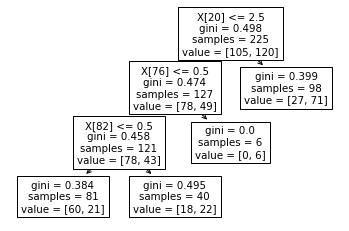

In [53]:
# Print the tree

tree.plot_tree(dt_3)
plt.show()

AUC:  0.7017543859649122
Precision:  0.6764705882352942
Recall:  0.7931034482758621


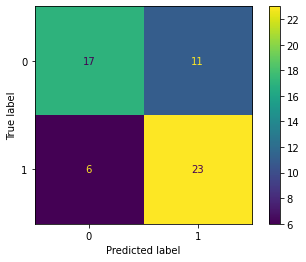

In [54]:
# Evaluación del modelo:

# Aplicamos el modelo a X_test
dt_predictions_3 = dt_3.predict(X_test_3)

# Obtenemos el accuracy, la precision y el recall
print('AUC: ', metrics.accuracy_score(y_test_3, dt_predictions_3))
print('Precision: ', metrics.precision_score(y_test_3, dt_predictions_3))
print('Recall: ', metrics.recall_score(y_test_3, dt_predictions_3))

# Calculamos la matrix de confusion
ConfusionMatrixDisplay.from_predictions(y_test_3, dt_predictions_3)
plt.show()

### Regresion Logistica

AUC:  0.7192982456140351
Precision:  0.7241379310344828
Recall:  0.7241379310344828


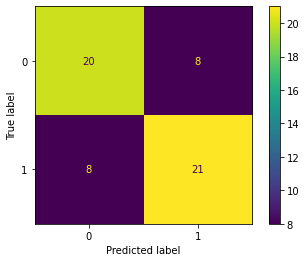

In [55]:
# Aplicamos el modelo de regresión logística.

lr_3 = LogisticRegression(max_iter = 1000, random_state = 1).fit(X_train_3, y_train_3)


# Evaluación del modelo:

# Aplicamos el modelo a X_test
lr_predictions_3 = lr_3.predict(X_test_3)

# Obtenemos el accuracy, la precision y el recall
print('AUC: ', metrics.accuracy_score(y_test_3, lr_predictions_3))
print('Precision: ', metrics.precision_score(y_test_3, lr_predictions_3))
print('Recall: ', metrics.recall_score(y_test_3, lr_predictions_3))

# Calculamos la matrix de confusion
ConfusionMatrixDisplay.from_predictions(y_test_3, lr_predictions_3)
plt.show()

### Random forest

AUC:  0.7543859649122807
Precision:  0.7419354838709677
Recall:  0.7931034482758621


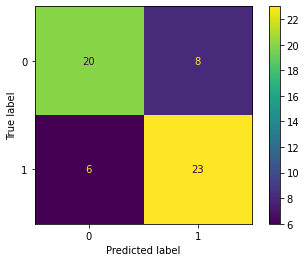

In [56]:
# Aplicamos el modelo de random forest

rf_3 = RandomForestClassifier(max_depth = 4, random_state = 1).fit(X_train_3, y_train_3)


# Evaluación del modelo:

# Aplicamos el modelo a X_test
rf_predictions_3 = rf_3.predict(X_test_3)

# Obtenemos el accuracy, la precision y el recall
print('AUC: ', metrics.accuracy_score(y_test_3, rf_predictions_3))
print('Precision: ', metrics.precision_score(y_test_3, rf_predictions_3))
print('Recall: ', metrics.recall_score(y_test_3, rf_predictions_3))

# Calculamos la matrix de confusion
ConfusionMatrixDisplay.from_predictions(y_test_3, rf_predictions_3)
plt.show()

Con este modelo hemos conseguido los mejores resultados en cada uno de los algoritmos. El AUC y el recall ya no son tan bajos, pero la precision ha bajado respecto a los otros modelos de datos.

Podriamos tambien plantearnos eliminar algunas de las columnas de 'start_xday_Delta' dejando por ejemplo solo el acumulado de las dos primeras semanas y el total. Pero eliminar mas variables no nos asegura una mejor performance del modelo y siendo variables sin nulos y sin correlaciones altas y esto no nos da suficiente justificación para hacerlo.

## Conclusiones

El modelo de datos con el one hot encoder es el que tiene mejores resultados en general, pero tiene una precission baja y como nuestro objetivo es captar nuevos clientes es importante tener en cuenta que estrategia quiere llavar a cabo el equipo de marketing.

Si disponen de un presupuesto pequeño y quieren asegurarse que con sus acciones se dirigen a un cliente potencial sera mejor proponer usar el modelo 2 que es el que tiene mas precission. Si por otro lado su objetivo es llegar al maximo de gente y solo quieren descartar los que casi seguro no van a comprar entonces el modelo 3 sera el mejor ya que tiene el mejor recall, que es lo que nos interesa en este caso.

Deberiamos dejar esto claro para elejir que modelo usar finalmente en función de sus preferencias. Pero como debemos hacer un predicción con los datos que nos han proporcionado vamos a usar el random forest del modelo 3 para intentar tener un mejor resulado.

Desde el punto de vista de kpis, la variable mas relevante ya que aparece en todos los decision trees es 'Form HandlerC', si este valor es mayor que 2.5 es un buen de que el cliente comprara.

## Predicciones

### ETL

Hacemos el mismo proceso de ETL en los datos de prediccion para conseguir el modelo de datos 3

In [57]:
# Cargamos los datos de predict
data_predict = pd.read_excel('data/data_PQLpredict.xlsx', header = 0, sheet_name = 'RapidMiner Data', engine = 'openpyxl')

In [58]:
# Creamos una variable nueva indicando si el usuario tiene algun registro de uso del programa o no
t1 = data_predict.copy()
t1['registered_usage'] = data_predict[null_col].any(axis=1).replace({False: 0., True: 1.})

# Eliminamos las columnas de uso dejando la nueva columna
t2 = t1.drop(columns = null_col)

# Eliminamos las columnas con solo zeros
t3 = t2.drop(columns =['Paid Search AdC', 'VideoC'])

# Seleccionamos las columnas que vamos a eliminar
s_remove = t3.columns[1:14]

# Eliminamos las columnas
t4 = t3.drop(columns = s_remove)

# Le quitamos la variable 'job_title'
t6 = t4.drop(columns = 'job_title')

# Generamos los one hot encodings para los datos de predict
country_dummies = pd.get_dummies(t6['country'], prefix = 'Country')
industry_dummies = pd.get_dummies(t6['industry'], prefix = 'industry')
job_function_dummies = pd.get_dummies(t6['job_function'], prefix = 'job_function')

# Reindexamos los encodigs para que se correspondan con los que teniamos en los datos de entrenamiento
country_dummies = country_dummies.reindex(columns = one_hot_country.columns, fill_value=0)
industry_dummies = industry_dummies.reindex(columns = one_hot_industry.columns, fill_value=0)
job_function_dummies = job_function_dummies.reindex(columns = one_hot_job_function.columns, fill_value=0)

# Añadimos las nuevas columnas al data set
t7 = t6.join(country_dummies)
t7 = t7.join(industry_dummies)
t7 = t7.join(job_function_dummies)

# Quitamos las variables que eran strings y la variable target que se dejo vacia en el documento
clean_data_predict = t7.drop(columns = ['Unnamed: 306', 'country', 'industry', 'job_function'])

ids = clean_data_predict.pop('id')

In [59]:
# Make the predictions

# Generate an empty dataframe to join the ID with the prediction
predictions = pd.DataFrame()

# Add the ID to the dataframe
predictions['id'] = ids

# Add the prediction as a Serie
predictions['IsWon'] = rf_3.predict(clean_data_predict)

# Export the result into a csv
predictions.to_csv('resultado_pred.csv')